### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Importing the files


*   Train set
*   Test set
*   Test Solutions set 



In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [63]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
file_id = '1TTvLZ7TLlQz95byhaSqoKzQxQtfdLee2'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':'1TTvLZ7TLlQz95byhaSqoKzQxQtfdLee2'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train_set.csv')  

# Read file as panda dataframe
import pandas as pd
train_df = pd.read_csv('train_set.csv') 


In [64]:
file_id = '1oErLhYHcKVPvyXeShiTBofg2-hQxoRfT'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':'1oErLhYHcKVPvyXeShiTBofg2-hQxoRfT'}) # replace the id with id of file you want to access
downloaded.GetContentFile('test_set.csv')  

# Read file as panda dataframe
import pandas as pd
test_df = pd.read_csv('test_set.csv') 


In [6]:
file_id = '1SlYEdNdkDHqP_Cxy6tSjawGJ4zTqLhUF'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id': file_id}) # replace the id with id of file you want to access
downloaded.GetContentFile('test_solutions.csv')  

# Read file as panda dataframe
import pandas as pd
test_solutions = pd.read_csv('test_solutions.csv') 

### Data Pre-processing

In [7]:
train_df.isnull().sum()

ambient           0
coolant           0
u_d               0
u_q               0
motor_speed       0
torque            0
i_d               0
i_q               0
pm                0
stator_yoke       0
stator_tooth      0
stator_winding    0
profile_id        0
dtype: int64

### Heatmap to detect Correlation

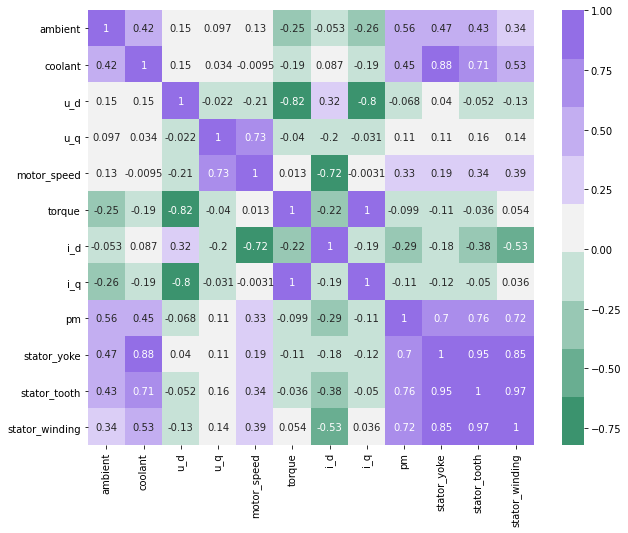

In [8]:
train_df1 = train_df.drop('profile_id', axis = 1)
plt.figure(figsize = (10,8))
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9)
sns.heatmap(train_df1.corr(), cmap= cmap,annot= True)

### Detecting Outliers using Box plot

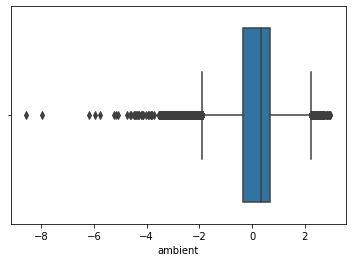

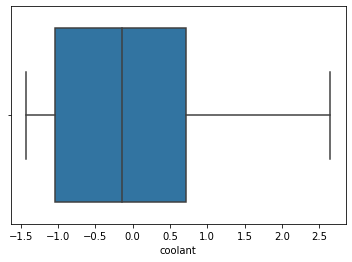

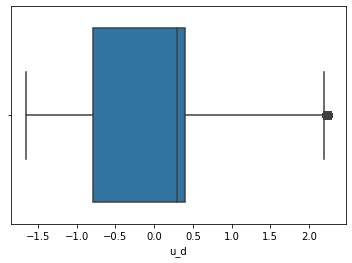

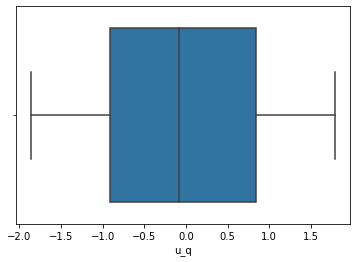

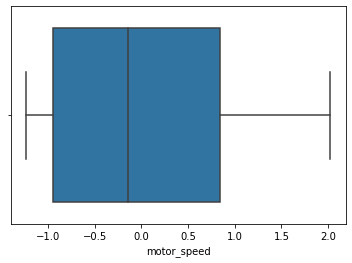

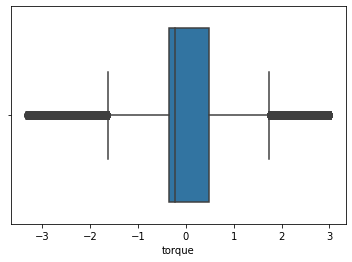

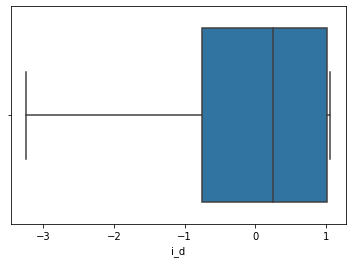

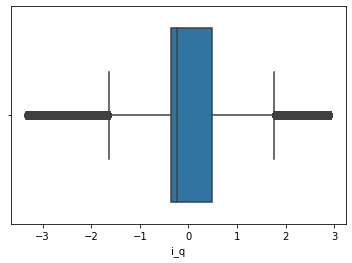

In [9]:
df2 = ['ambient','coolant','u_d','u_q','motor_speed','torque','i_d','i_q']
for i in df2:
    sns.boxplot(train_df[i])
    plt.show()

In [10]:
train_df.torque.describe()

count    846368.000000
mean         -0.041547
std           1.000715
min          -3.345953
25%          -0.365100
50%          -0.237407
75%           0.472951
max           3.016971
Name: torque, dtype: float64

In [11]:
train_df.i_q.describe()

count    846368.000000
mean         -0.040897
std           1.000951
min          -3.341639
25%          -0.362148
50%          -0.245697
75%           0.486917
max           2.914185
Name: i_q, dtype: float64

In [12]:
Min_torque = -0.365 - (1.5 * 0.837)
Max_torque = 0.472 + (1.5 * 0.837)
print('Min_torque: ', Min_torque)
print('Max_torque: ', Max_torque)
Min_iq = -0.362 - (1.5 * 0.849)
Max_iq = 0.487 + (1.5 * 0.849)
print('Min_iq: ', Min_iq)
print('Max_iq: ', Max_iq)

Min_torque:  -1.6205
Max_torque:  1.7275
Min_iq:  -1.6355
Max_iq:  1.7605


In [13]:
new_train_df = train_df.loc[~((train_df['ambient'] < -2) | (train_df['ambient'] > 2) | (train_df['u_d'] > 2) | (train_df['torque'] < Min_torque) | (train_df['torque'] > Max_torque) | (train_df['i_q'] < Min_iq) | (train_df['i_q'] > Max_iq)),:]
new_train_df

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
846363,-0.047497,0.341638,0.331475,-1.246114,-1.222428,-0.255640,1.029142,-0.245723,0.429853,1.018568,0.836084,0.494725,72
846364,-0.048839,0.320022,0.331701,-1.250655,-1.222437,-0.255640,1.029148,-0.245736,0.429751,1.013417,0.834438,0.494279,72
846365,-0.042350,0.307415,0.330946,-1.246852,-1.222430,-0.255640,1.029191,-0.245701,0.429439,1.002906,0.833936,0.492666,72
846366,-0.039433,0.302082,0.330987,-1.249505,-1.222432,-0.255640,1.029147,-0.245727,0.429558,0.999157,0.830504,0.490581,72


### Exploratory Data Analysis

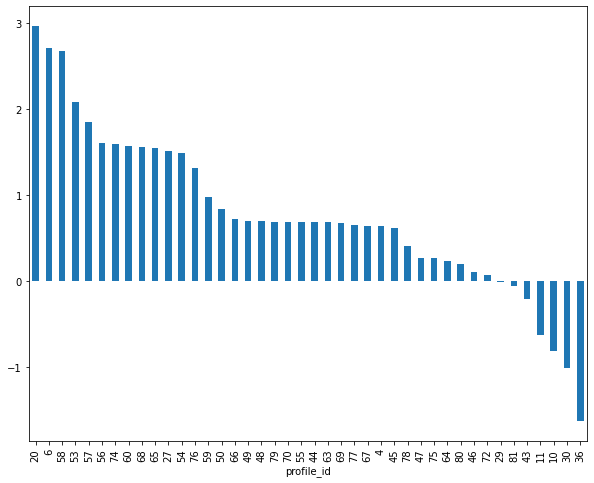

In [14]:
plt.figure(figsize = (10,8))
train_df.groupby('profile_id').agg('max')['ambient'].sort_values(ascending = False).plot(kind = 'bar')

#### Feature Engineering

##### We add a new column 'recording_second' which says the particular second when the recording is done for each profile_id 

In [15]:
abc = new_train_df.profile_id.unique()
xyz1 = []
for i in abc:
    counter = 0
    for j in new_train_df['profile_id']:
        if i == j:
            counter = counter + 0.5
            xyz1.append(counter)


In [16]:
len(xyz1)

692270

In [17]:
new_train_df['recording_second'] = xyz1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
new_train_df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id,recording_second
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4,0.5
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4,1.0
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4,1.5
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4,2.0
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4,2.5


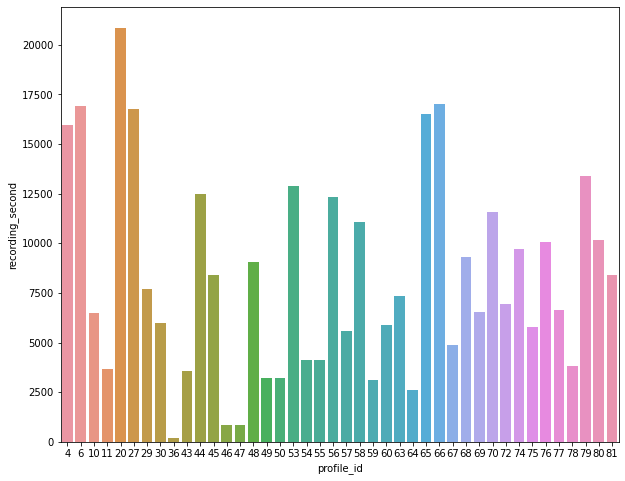

In [19]:
df3 = new_train_df.groupby('profile_id').agg('max')
plt.figure(figsize = (10,8))
sns.barplot(x = df3.index, y= 'recording_second', data = df3)

##### The max amount of time ran by a profile_id is 5.8 hours which is by profile-id 20.

##### The min amount of time ran by a profile_id is 3.1 minutes which is by profile-id 36.

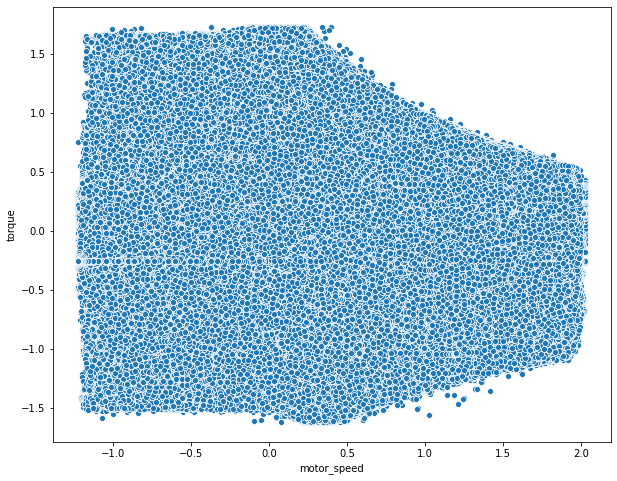

In [20]:
plt.figure(figsize = (10,8))
sns.scatterplot(x = 'motor_speed', y = 'torque', data = new_train_df)

##### As torque is in high-end initially in an electric car until motor speed(rpm) of 0.3 from where horse power remains stable, the pickup speed with be really fast when compared to a gas car and even though the motor speed(rpm) slows down later, it increases at higher ranges.

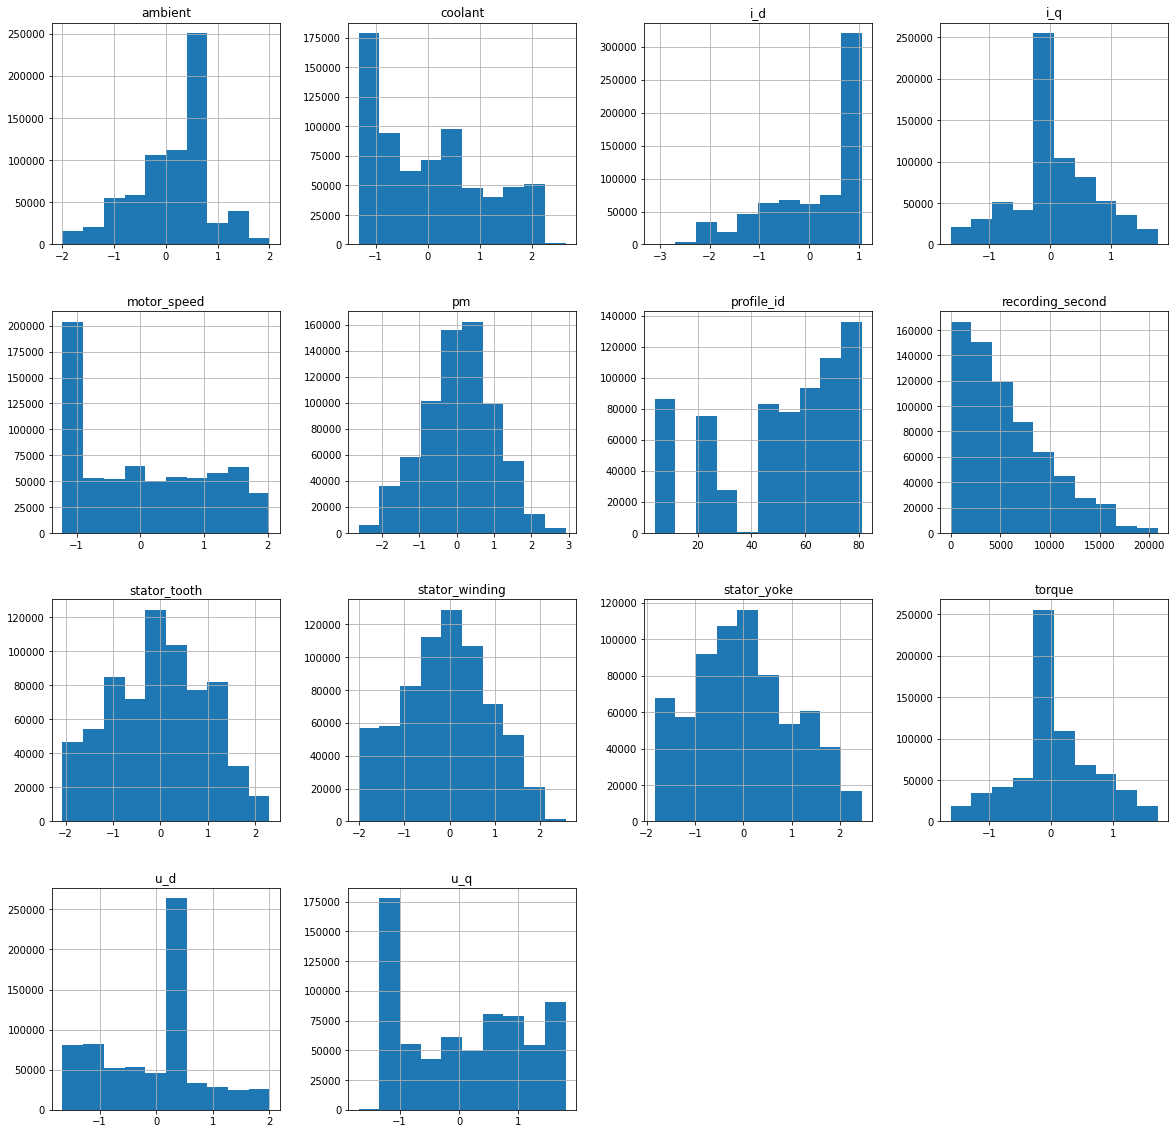

In [21]:
new_train_df.hist(figsize = (20,20))
plt.show()

##### Except coolant temperature, i_d, motor speed, u_q, recording second rest of the columns are normally distributed

### Model Building

#### Predicting 'pm'

In [22]:
X = new_train_df.drop(columns = ['u_d','stator_yoke','stator_tooth','pm','stator_winding','profile_id','recording_second'])
y = new_train_df['pm']
test_df1 = test_df.drop(columns= ['u_d'])

In [23]:
new_train_df.corr()['pm']

ambient             0.419881
coolant             0.389304
u_d                -0.166444
u_q                 0.073854
motor_speed         0.311387
torque              0.060334
i_d                -0.346705
i_q                 0.035233
pm                  1.000000
stator_yoke         0.669635
stator_tooth        0.770697
stator_winding      0.776355
profile_id          0.141589
recording_second    0.156379
Name: pm, dtype: float64

#### Linear Regression

In [24]:
model1 = LinearRegression().fit(X, y)
pred_pm = model1.predict(test_df1)
val = mean_squared_error(test_solutions['pm'],pred_pm)
val1 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.9577638933620191


#### K-NN Regressor

In [25]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

transformed_scaler_testset = scaler.transform(test_df1)

Text(0, 0.5, 'Error rate')

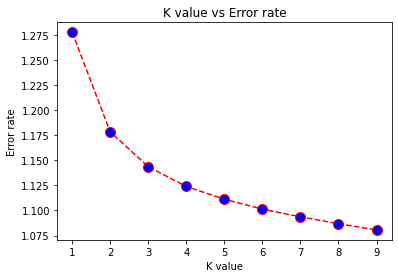

In [26]:

error_rate = []
for i in range(1,10):
    knn = KNeighborsRegressor(n_neighbors=i)
    score = cross_val_score(knn,X,y, cv = 10)
    error_rate.append(1-score.mean())
    
plt.plot(range(1,10), error_rate, color = 'red', linestyle = 'dashed', marker = 'o', markerfacecolor = 'blue', markersize = 10)
plt.title('K value vs Error rate')
plt.xlabel('K value')
plt.ylabel('Error rate')


In [27]:
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X,y)
pred_pm = knn.predict(transformed_scaler_testset)
val = mean_squared_error(test_solutions['pm'],pred_pm)
val2 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 1.135284354507868


In [28]:
X = new_train_df
X = new_train_df.drop(columns = ['u_d','stator_yoke','stator_tooth','stator_winding','profile_id','recording_second','pm'])

#### Random Forest Regressor

In [29]:
model3 = RandomForestRegressor(n_estimators=100,min_samples_leaf=2,min_samples_split=3, max_features=0.5 ,n_jobs=-1)
model3.fit(X,y)
pred_pm = model3.predict(test_df1)
val = mean_squared_error(test_solutions['pm'],pred_pm)
val3 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.988497030578439


#### Decision Tree Regressor

In [30]:
model4 = DecisionTreeRegressor()
model4.fit(X,y)
pred_pm = model4.predict(test_df1)
val = mean_squared_error(test_solutions['pm'],pred_pm)
val4 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 1.140599993602849


#### Gradient Boosting Regressor

In [31]:
model5 = GradientBoostingRegressor()
model5.fit(X,y)
pred_pm = model5.predict(test_df1)
val = mean_squared_error(test_solutions['pm'],pred_pm)
val5 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.8828783504103523


#### XG Boosting Regressor

In [32]:
model6 = xgboost.XGBRegressor()
model6.fit(X,y)
pred_pm = model6.predict(test_df1)
val = mean_squared_error(test_solutions['pm'],pred_pm)
val6 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

[01:49:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE : 0.8793012183393626


#### Model Evaluation

In [33]:
rmse_pm = {'ML Algorithm' : ['Linear Regressor','K-NN Regressor', 'Random Forest Regressor', 'Decision Tree Regressor', 'Gradient Boosting Regressor','XG Boosting Regressor']
	   ,'RMSE' : [val1,val2,val3,val4,val5,val6] } 
pd.DataFrame(rmse_pm)

,ML Algorithm,RMSE
0,Linear Regressor,0.957764
1,K-NN Regressor,1.135284
2,Random Forest Regressor,0.988497
3,Decision Tree Regressor,1.140600
4,Gradient Boosting Regressor,0.882878
5,XG Boosting Regressor,0.879301


##### Out of the above, XG Boosting Regressor has the lowest RMSE. So, we choose it for 'pm_predicted'

In [40]:
pm_predicted = pred_pm
RMSE_pm = val6

#### Predicting 'stator_yoke'

In [43]:
X = new_train_df.drop(columns = ['u_d','pm','coolant','stator_yoke','stator_tooth','stator_winding','profile_id','recording_second'])
y = new_train_df['stator_yoke']
test_df = test_df.drop(columns = ['coolant','u_d'])

In [44]:
new_train_df.corr()['stator_yoke']

ambient             0.409613
coolant             0.889324
u_d                -0.009111
u_q                 0.120279
motor_speed         0.187145
torque             -0.041112
i_d                -0.173002
i_q                -0.052602
pm                  0.669635
stator_yoke         1.000000
stator_tooth        0.952311
stator_winding      0.861266
profile_id          0.416504
recording_second   -0.060451
Name: stator_yoke, dtype: float64

#### Linear Regression

In [45]:
model1 = LinearRegression().fit(X, y)
pred_stator_yoke = model1.predict(test_df)
val = mean_squared_error(test_solutions['stator_yoke'],pred_stator_yoke)
val1 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.7833198588876884


#### K-NN Regression

In [46]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
transformed_scaler_testset = scaler.transform(test_df)

Text(0, 0.5, 'Error rate')

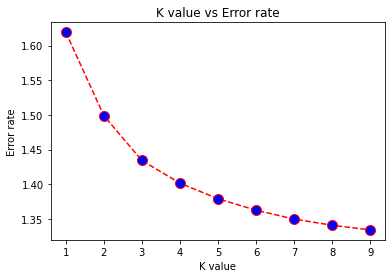

In [47]:

error_rate = []
for i in range(1,10):
    knn = KNeighborsRegressor(n_neighbors=i)
    score = cross_val_score(knn,X,y, cv = 10)
    error_rate.append(1-score.mean())

    
plt.plot(range(1,10), error_rate, color = 'red', linestyle = 'dashed', marker = 'o', markerfacecolor = 'blue', markersize = 10)
plt.title('K value vs Error rate')
plt.xlabel('K value')
plt.ylabel('Error rate')

In [48]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X,y)
pred_stator_yoke = knn.predict(transformed_scaler_testset)
val = mean_squared_error(test_solutions['stator_yoke'],pred_stator_yoke)
val2 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.9179165269697099


In [49]:
X = new_train_df
X = new_train_df.drop(columns = ['coolant','u_d','stator_yoke','stator_tooth','stator_winding','profile_id','pm','recording_second'])

#### Random Forest Regression

In [50]:
model3 = RandomForestRegressor()
model3.fit(X,y)
pred_stator_yoke = model3.predict(test_df)
val = mean_squared_error(test_solutions['stator_yoke'],pred_stator_yoke)
val3 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.8166822611390818


#### Decision Tree Regression

In [51]:
model4 = DecisionTreeRegressor()
model4.fit(X,y)
pred_stator_yoke = model4.predict(test_df)
val = mean_squared_error(test_solutions['stator_yoke'],pred_stator_yoke)
val4 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.9613862446461883


#### Gradient Boosting Regression

In [52]:
model5 = GradientBoostingRegressor()
model5.fit(X,y)
pred_stator_yoke = model5.predict(test_df)
val = mean_squared_error(test_solutions['stator_yoke'],pred_stator_yoke)
val5 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.6701570083297308


#### XG Boosting Regression

In [53]:
model6 = xgboost.XGBRegressor()
model6.fit(X,y)
pred_stator_yoke = model6.predict(test_df)
val = mean_squared_error(test_solutions['stator_yoke'],pred_stator_yoke)
val6 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

[02:45:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE : 0.6555663123425503


#### Model Evaluation

In [54]:
rmse_stator_yoke = {'ML Algorithm' : ['Linear','KNN Regressor', 'Random Forest Regressor', 'Decision Tree Regressor', 'Gradient Boosting Regressor','XG Boosting Regressor']
	   ,'RMSE' : [val1,val2,val3,val4,val5,val6] } 
pd.DataFrame(rmse_stator_yoke)

,ML Algorithm,RMSE
0,Linear,0.783320
1,KNN Regressor,0.917917
2,Random Forest Regressor,0.816682
3,Decision Tree Regressor,0.961386
4,Gradient Boosting Regressor,0.670157
5,XG Boosting Regressor,0.655566


Out of all the ML Algorithms, Linear Regressor has the lowest RMSE 0.66, so we choose it for 'stator_yoke_predicted'

In [56]:
RMSE_stator_yoke = val1
stator_yoke_predicted = pred_stator_yoke  

#### Predicting 'stator_tooth'

In [57]:
X = new_train_df
X = new_train_df.drop(columns = ['u_d','pm','stator_yoke','stator_tooth','stator_winding','profile_id','recording_second'])
y = new_train_df['stator_tooth']

In [65]:
test_df3 = test_df
test_df3 = test_df.drop(columns= ['u_d'])

#### Linear Regression

In [66]:
model1 = LinearRegression().fit(X, y)
pred_stator_tooth = model1.predict(test_df3)
val = mean_squared_error(test_solutions['stator_tooth'],pred_stator_tooth)
val1 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.6401551021242478


#### K-NN Regression

Text(0, 0.5, 'Error rate')

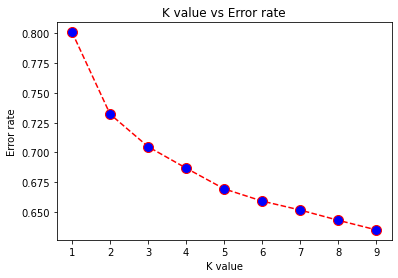

In [67]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
transformed_scaler_testset = scaler.transform(test_df3)


error_rate = []
for i in range(1,10):
    knn = KNeighborsRegressor(n_neighbors=i)
    score = cross_val_score(knn,X,y, cv = 10)
    error_rate.append(1-score.mean())

    
plt.plot(range(1,10), error_rate, color = 'red', linestyle = 'dashed', marker = 'o', markerfacecolor = 'blue', markersize = 10)
plt.title('K value vs Error rate')
plt.xlabel('K value')
plt.ylabel('Error rate')


In [68]:
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X,y)
pred_stator_tooth = knn.predict(transformed_scaler_testset)
val = mean_squared_error(test_solutions['stator_tooth'],pred_stator_tooth)
val2 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.8093744121867592


In [69]:
X = new_train_df
X = new_train_df.drop(columns = ['u_d','stator_yoke','stator_tooth','stator_winding','profile_id','pm','recording_second'])
test_df3 = test_df.drop(columns = ['u_d'])

#### Random Forest Regression

In [70]:
model3 = RandomForestRegressor()
model3.fit(X,y)
pred_stator_tooth = model3.predict(test_df3)
val = mean_squared_error(test_solutions['stator_tooth'],pred_stator_tooth)
val3 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.6639840148035784


#### Decision Tree Regression

In [71]:
model4 = DecisionTreeRegressor()
model4.fit(X,y)
pred_stator_tooth = model4.predict(test_df3)
val = mean_squared_error(test_solutions['stator_tooth'],pred_stator_tooth)
val4 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.8296923018185186


#### Gradient Boosting Regression

In [72]:
model5 = GradientBoostingRegressor()
model5.fit(X,y)
pred_stator_tooth = model5.predict(test_df3)
val = mean_squared_error(test_solutions['stator_tooth'],pred_stator_tooth)
val5 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.5414507121817519


#### XG Boosting Regression

In [73]:
model6 = xgboost.XGBRegressor()
model6.fit(X,y)
pred_stator_tooth = model6.predict(test_df3)
val = mean_squared_error(test_solutions['stator_tooth'],pred_stator_tooth)
val6 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

[03:30:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE : 0.5405701520870574


In [74]:
rmse_stator_tooth = {'ML Algorithm' : ['Linear','KNN Regressor', 'Random Forest Regressor', 'Decision Tree Regressor', 'Gradient Boosting Regressor','XG Boosting Regressor']
	   ,'RMSE' : [val1,val2,val3,val4,val5,val6] } 
pd.DataFrame(rmse_stator_tooth)


,ML Algorithm,RMSE
0,Linear,0.640155
1,KNN Regressor,0.809374
2,Random Forest Regressor,0.663984
3,Decision Tree Regressor,0.829692
4,Gradient Boosting Regressor,0.541451
5,XG Boosting Regressor,0.540570


##### Out of the ML algorithms, XG Boosting Regressor has the lowest RMSE, so we select it as 'stator_tooth_predicted'

In [75]:
RMSE_stator_tooth = val5
stator_tooth_predicted = pred_stator_tooth

#### Predicting 'stator_winding'

In [76]:
y = new_train_df['stator_winding']
X = new_train_df
X = new_train_df.drop(columns = ['u_d','stator_yoke','stator_tooth','stator_winding','profile_id','pm','recording_second'])

In [77]:
test_df4 = test_df.drop(columns = ['u_d'])

#### Linear Regression

In [78]:
model1 = LinearRegression().fit(X, y)
pred_stator_winding = model1.predict(test_df4)
val = mean_squared_error(test_solutions['stator_winding'],pred_stator_winding)
val1 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.7130428122774145


#### K-NN Regression

Text(0, 0.5, 'Error rate')

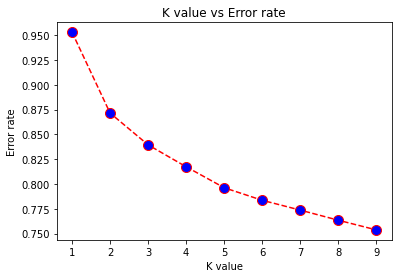

In [79]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
transformed_scaler_testset = scaler.transform(test_df4)


error_rate = []
for i in range(1,10):
    knn = KNeighborsRegressor(n_neighbors=i)
    score = cross_val_score(knn,X,y, cv = 10)
    error_rate.append(1-score.mean())

    
plt.plot(range(1,10), error_rate, color = 'red', linestyle = 'dashed', marker = 'o', markerfacecolor = 'blue', markersize = 10)
plt.title('K value vs Error rate')
plt.xlabel('K value')
plt.ylabel('Error rate')

In [80]:
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X,y)
pred_stator_winding = knn.predict(transformed_scaler_testset)
val = mean_squared_error(test_solutions['stator_winding'],pred_stator_winding)
val2 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.9316925331658876


In [81]:
X = new_train_df
X = new_train_df.drop(columns = ['u_d','stator_yoke','stator_tooth','stator_winding','profile_id','pm','recording_second'])
test_df4 = test_df.drop(columns= ['u_d'])

#### Random Forest Regression

In [82]:
model3 = RandomForestRegressor()
model3.fit(X,y)
pred_stator_winding = model3.predict(test_df4)
val = mean_squared_error(test_solutions['stator_winding'],pred_stator_winding)
val3 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.8504744476208386


#### Decision Tree Regression

In [83]:
model4 = DecisionTreeRegressor()
model4.fit(X,y)
pred_stator_winding = model4.predict(test_df4)
val = mean_squared_error(test_solutions['stator_winding'],pred_stator_winding)
val4 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 1.143053233067583


#### Gradient Boosting Regression

In [84]:
model5 = GradientBoostingRegressor()
model5.fit(X,y)
pred_stator_winding = model5.predict(test_df4)
val = mean_squared_error(test_solutions['stator_winding'],pred_stator_winding)
val5 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

RMSE : 0.5887662132388269


#### XG Boosting Regression

In [85]:
model6 = xgboost.XGBRegressor()
model6.fit(X,y)
pred_stator_winding = model6.predict(test_df4)
val = mean_squared_error(test_solutions['stator_winding'],pred_stator_winding)
val6 = math.sqrt(val)
print('RMSE : {}'.format(math.sqrt(val)))

[03:50:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE : 0.5995630932960424


#### Model Evaluation

In [86]:
rmse_stator_winding = {'ML Algorithm' : ['Linear','KNN Regressor', 'Random Forest Regressor', 'Decision Tree Regressor', 'Gradient Boosting Regressor','XG Boosting Regressor']
	   ,'RMSE' : [val1,val2,val3,val4,val5,val6] } 
pd.DataFrame(rmse_stator_winding)

,ML Algorithm,RMSE
0,Linear,0.713043
1,KNN Regressor,0.931693
2,Random Forest Regressor,0.850474
3,Decision Tree Regressor,1.143053
4,Gradient Boosting Regressor,0.588766
5,XG Boosting Regressor,0.599563


##### Out of all the ML algorithms, Gradient Boosting Regressor has the lowest RMSE of 0.594

In [87]:
stator_winding_predicted = pred_stator_winding
RMSE_stator_winding = val5

In [88]:
test_df['pm_predicted'] = pm_predicted
test_df['stator_yoke_predicted'] = stator_yoke_predicted
test_df['stator_tooth_predicted'] = stator_tooth_predicted
test_df['stator_winding_predicted'] = stator_winding_predicted

In [89]:
test_df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm_predicted,stator_yoke_predicted,stator_tooth_predicted,stator_winding_predicted
0,-2.749564,-1.073478,0.336463,-1.295874,-1.222426,-0.248547,1.041590,-0.250223,-1.034671,-1.034671,-1.697258,-1.596942
1,-2.749612,-1.072823,0.339015,-1.298281,-1.222425,-0.247740,1.038055,-0.248936,-1.034671,-1.034671,-1.697258,-1.596942
2,-2.746339,-1.073277,0.340775,-1.299160,-1.222428,-0.247232,1.035532,-0.248042,-1.162928,-1.162928,-1.697258,-1.618545
3,-2.747337,-1.074854,0.341972,-1.300307,-1.222428,-0.246810,1.033727,-0.247364,-1.162928,-1.162928,-1.701664,-1.637840
4,-2.748052,-1.076696,0.344047,-1.301804,-1.222429,-0.246473,1.032427,-0.246897,-1.162928,-1.162928,-1.703903,-1.637840


In [96]:
from google.colab import files
test_df.to_csv('test_df.csv') 
files.download('test_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>